### Classification Trees

This notebook explores several metrics used to evaluate the quality of decision tree splits (information gain) and hence to build trees in the binary classification setting. 

Code for performing single splits is included to demonstrate how information gain is used to decide on the best feature and point to split on in the standard greedy algorithm approach. Plots at the end of the notebook show example splits on 3 impurity metrics.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import numpy as np
np.random.seed(10)

**Impurity metrics**

Classification error, gini, and entropy are all used to measure the "impurity" of a node in a decision tree. The higher the metric the more impure the node. Intuitively, more impurity means that there is more of a mix of classes - that the node has not done a good job seperating out the observed data points by their labels. For example, if a node contains samples from only one class label it has 0 impurity (ideal), while if a node has class labels split 50-50 it has maximum impurity.    

Here we give the formula for these metrics for a binary classification problem. For more general (multi-class) definitions and a good reference see [here](https://sebastianraschka.com/faq/docs/decision-tree-binary.html).

Classification error is typically not used to build trees because it is less sensitive to changes in class probabilities than would be ideal. Gini and entropy tend to give similar (though not identical) results in practice.

In [2]:
def get_bin_proportions(y):
    p_0 = sum(y == 0) / y.shape[0]
    p_1 = 1 - p_0
    return p_0, p_1

def class_error(y):
    return min(get_bin_proportions(y))

def bin_gini(y):
    p_0, p_1 = get_bin_proportions(y)
    return p_0 * (1 - p_0) + p_1 * (1 - p_1)

def bin_entropy(y):
    p_0, p_1 = get_bin_proportions(y)
    
    if (p_0 == 0 or p_1 == 0):
        return 0 
    else:
        return -1 * (p_0 * np.log2(p_0) + p_1 * np.log2(p_1))

Below we plot the 3 impurity metrics over the proportion of node samples belonging to class 1. Note the minima at 0% and 100%, and the maximum at 50%.

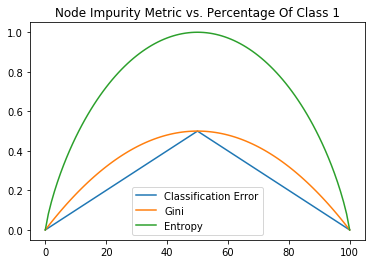

In [3]:
errors, ginis, entropies = [], [], []

for i in range(0,101):
    y = np.append(np.ones((i,1)), np.zeros((100-i,1)))
    errors.append(class_error(y))
    ginis.append(bin_gini(y))
    entropies.append(bin_entropy(y))

plt.plot(errors)
plt.plot(ginis)
plt.plot(entropies)
plt.title('Node Impurity Metric vs. Percentage Of Class 1')
plt.legend(labels=['Classification Error','Gini','Entropy'])

**Performing a tree split**

The code below shows how we would perform a single split on a given tree node, using maximum information gain.

Recall that information gain is given by $Gain = Imp(Parent) - [\frac{N_{left}}{N} * Imp(Left) + \frac{N_{right}}{N} * Imp(right)]$.

I.e. we compute the weighted impurity of children nodes and compare it with the impurity of the parent, looking to choose the split that yields the greatest difference across all the features in our data. This maximum information gain means we've found the feature/split point that gives the best seperation of the class labels, reducing the impurity as much as possible for this splitting stage.

In [4]:
np.where(np.array([3,4,5]) == 3)[0]

array([0])

In [5]:
''' Per feature split finder

    x, y: feature to split on and target  
    imp_metric: metric to use for splitting to maximize purity gain
    
    returns: best split index and purity gain
'''
def get_best_x_split(x, y, imp_metric):
    
    best_idx, best_purity_gain = 0, 0
    
    for idx, val in enumerate(np.sort(x)[1:]):

        y_left = y[np.where(x < val)]
        y_right = y[np.where(x >= val)]

        left_imp = imp_metric(y_left) * (y_left.shape[0] / y.shape[0]) 
        right_imp = imp_metric(y_right) * (y_right.shape[0] / y.shape[0])  
        purity_gain = imp_metric(y) - (left_imp + right_imp)   

        if purity_gain > best_purity_gain: 
            best_idx = np.where(x == val)[0] 
            best_purity_gain = purity_gain
     
    return best_idx, best_purity_gain 

''' Across all features split finder

    X, y: Features to split on and target  
    imp_metric: metric to use for splitting to maximize purity gain
    
    returns: best split feature and the corresponding split index
'''
def get_best_split(X, y, imp_metric):
    split_results = np.apply_along_axis(get_best_x_split, axis=0, arr=X,
                                        y=y, imp_metric=imp_metric)
    best_split_feature = np.argmin(split_results[1])
    best_split_idx = int(split_results[0][best_split_feature])
    
    return best_split_feature, best_split_idx

''' Splitting on feature function

    x, y: feature to split on and target  
    split_idx: index to split at, assumes sorted x
    
    returns: left/right splits of x and y arrays
'''
def tree_split(x, y, split_idx):
    
    val = np.sort(x)[split_idx]
    
    left_inds = np.where(x < val) 
    right_inds = np.where(x >= val) 
    
    x_left, x_right = x[left_inds], y[right_inds]
    y_left, y_right = y[left_inds], y[right_inds]
    
    return x_left, x_right, y_left, y_right

**Toy Data**

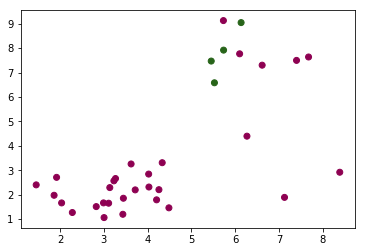

In [6]:
y = np.append(np.zeros((30,1)),
              np.ones((4,1)))

x1 = np.append(np.random.normal(loc=3, size=20),
               np.random.normal(loc=6, size=14))
x2 = np.append(np.random.normal(loc=2, size=25),
               np.random.normal(loc=8, size=9))

X = np.hstack((x1.reshape(-1,1),x2.reshape(-1,1)))

plt.scatter(x1, x2, c=y, cmap='PiYG')

**Splitting Examples**

Note that gini & entropy give the same splitting results in this case.

Classification Error Split

In [7]:
feature_class, ind_class = get_best_split(X, y, class_error)
#x_left, x_right, y_left, y_right = tree_split(X[:,feature_class], y, ind_class) 

print('Feature index: %d' % feature_class)
print('Split index: %d, split value: %.3f' % (ind_class,X[ind_class,feature_class]))

Feature index: 0
Split index: 5, split value: 2.280


Gini Split

In [8]:
feature_gini, ind_gini = get_best_split(X, y, bin_gini)
#x_left, x_right, y_left, y_right = tree_split(X[:,feature_gini], y, ind_gini) 

print('Feature index: %d' % feature_gini)
print('Split index: %d, split value: %.3f' % (ind_gini,X[ind_gini,feature_gini]))

Feature index: 0
Split index: 31, split value: 5.451


Entropy Split

In [9]:
feature_ent, ind_ent = get_best_split(X, y, bin_entropy)
#x_left, x_right, y_left, y_right = tree_split(X[:,feature_ent], y, ind_ent) 

print('Feature index: %d' % feature_ent)
print('Split index: %d, split value: %.3f' % (ind_ent,X[ind_ent,feature_ent]))

Feature index: 0
Split index: 31, split value: 5.451


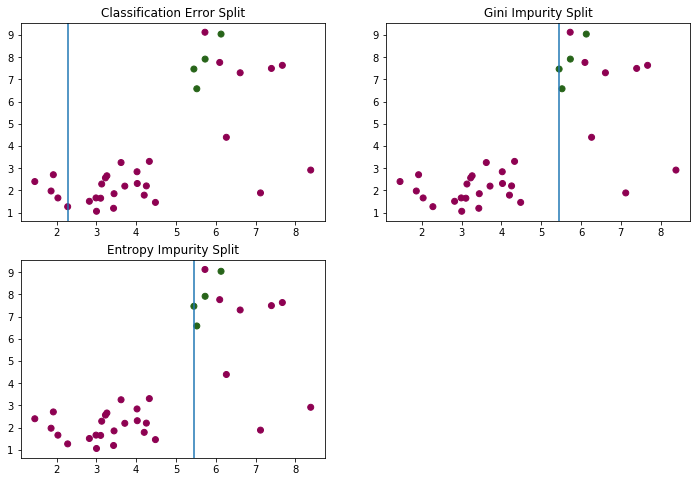

In [10]:
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12,8))
ax = plt.subplot(gs[0, 0]) 
plt.scatter(x1, x2, c=y, cmap='PiYG')
plt.axvline(X[ind_class,feature_class])
plt.title('Classification Error Split')

ax = plt.subplot(gs[0, 1]) 
plt.scatter(x1, x2, c=y, cmap='PiYG')
plt.axvline(X[ind_gini,feature_gini])
plt.title('Gini Impurity Split')

ax = plt.subplot(gs[1, 0]) 
plt.scatter(x1, x2, c=y, cmap='PiYG')
plt.axvline(X[ind_ent,feature_ent])
plt.title('Entropy Impurity Split')